In [1]:
import pystan
import numpy as np
import copy
import os
import matplotlib.pyplot as plt

np.random.seed(1)

# signal rate
lambda_s = 1.0

# distribution of bkg rates across all datasets
lambda_b_mean = 10.0
lambda_b_sigma = 2.0

time = 1.0

# parameters of signal and bkg pdfs
gaussian_mean = 2000.0
gaussian_sigma = 10.0
xmin = 1900.0
xmax = 2100.0


n_datasets = 20

# generate data
lambda_b = np.random.normal(lambda_b_mean, lambda_b_sigma, n_datasets) # vector of background rates in each dataset
lambda_b[lambda_b<0] = 0.0 # set negative rates to 0


p_s = lambda_s / (lambda_s + lambda_b)
n_obs = np.random.poisson((lambda_s + lambda_b)*time, n_datasets)  # total number of observed events in each dataset

n_obs_max = max(n_obs) # needed for padding of arrays in stan

n_s = np.random.binomial(n_obs, p_s, len(p_s))
n_b = n_obs - n_s

def rrunif(n):
  return np.random.uniform(xmin, xmax, n)


def rrnorm(n):
  return np.random.normal(gaussian_mean, gaussian_sigma, n)


x_obs_b = map(rrunif, n_b)
x_obs_s = map(rrnorm, n_s)

plotting dataset 0


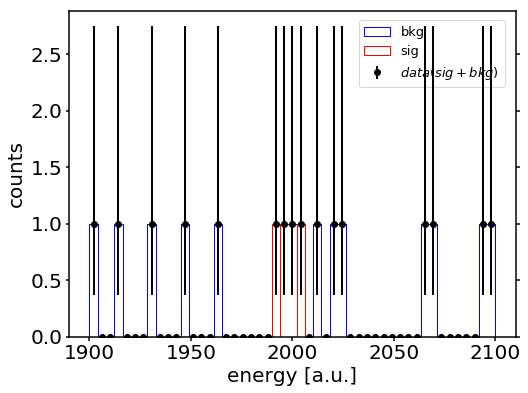

plotting dataset 1


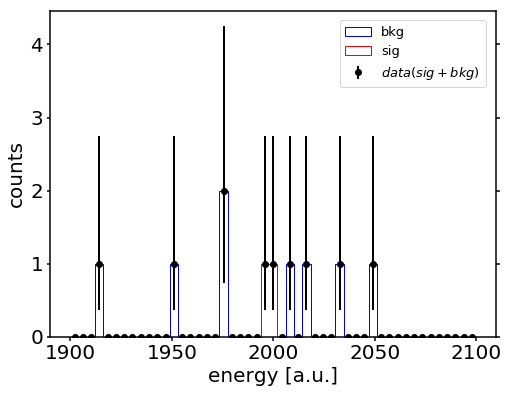

plotting dataset 2


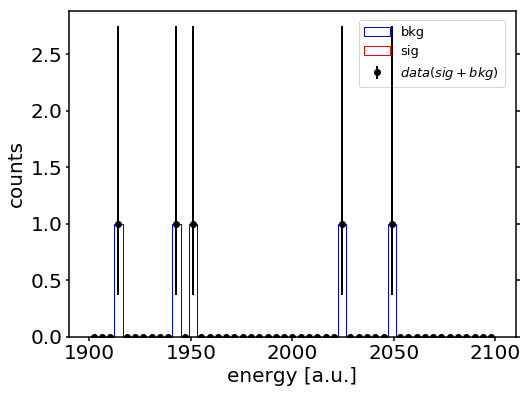

plotting dataset 3


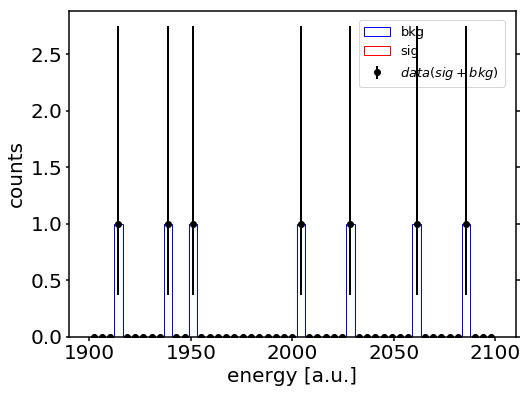

plotting dataset 4


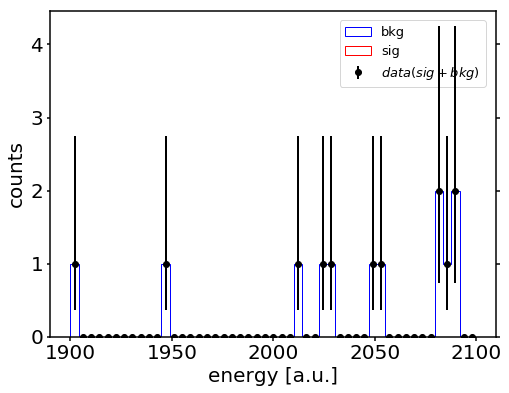

plotting dataset 5


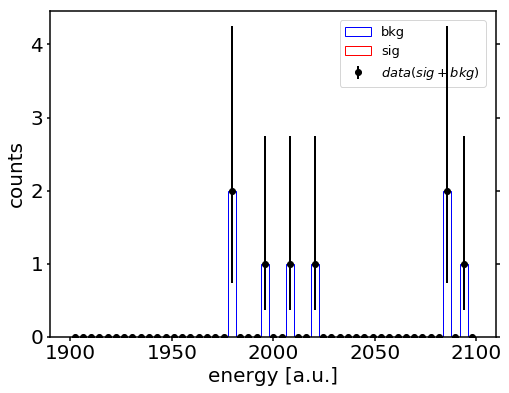

plotting dataset 6


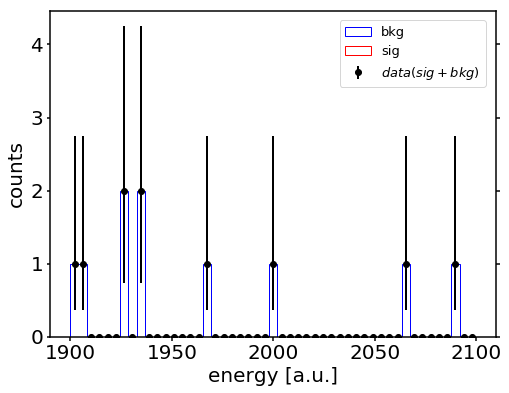

plotting dataset 7


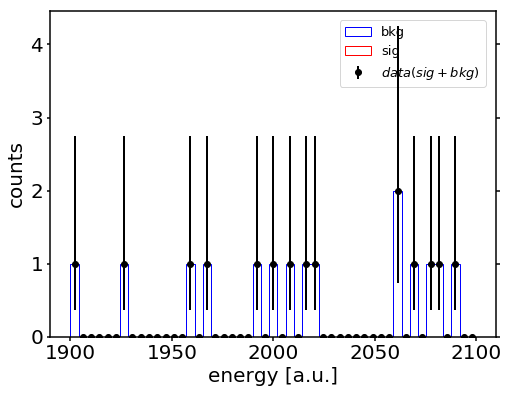

plotting dataset 8


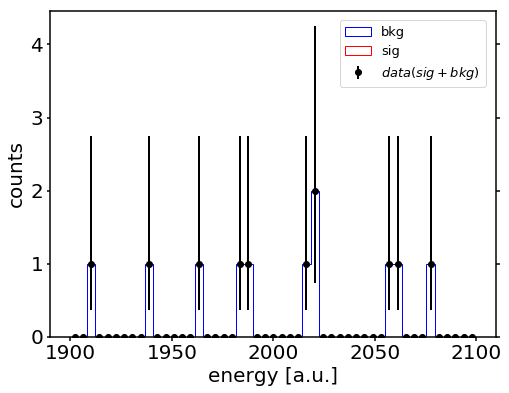

plotting dataset 9


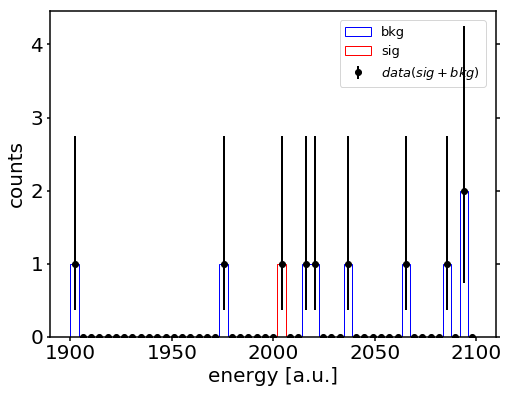

plotting dataset 10


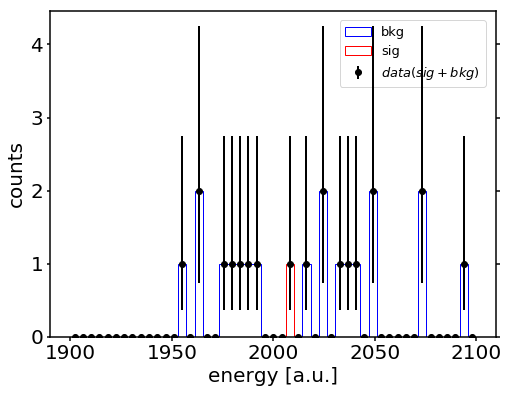

plotting dataset 11


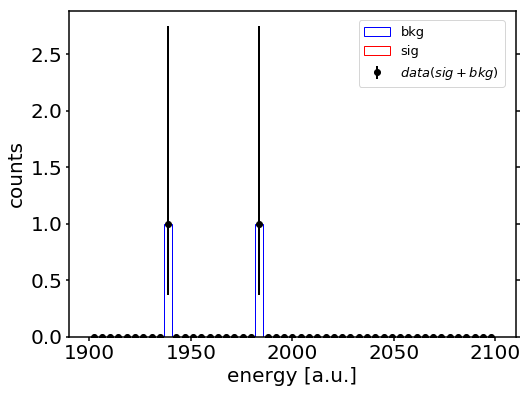

plotting dataset 12


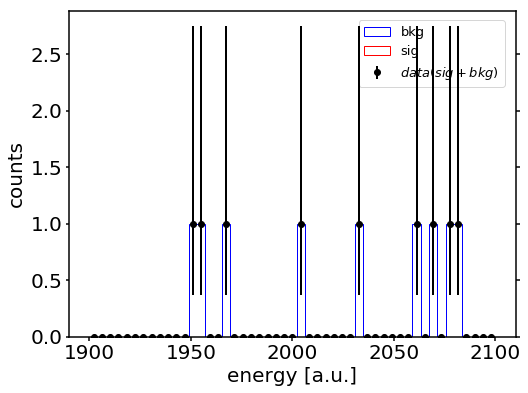

plotting dataset 13


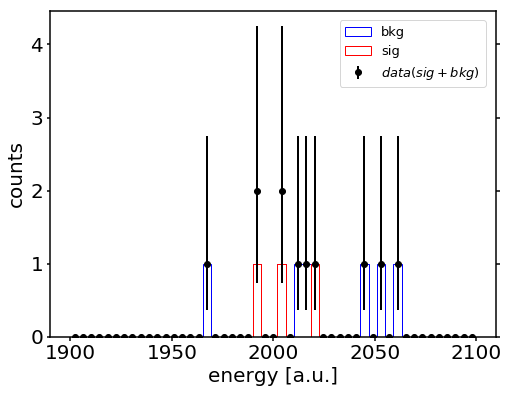

plotting dataset 14


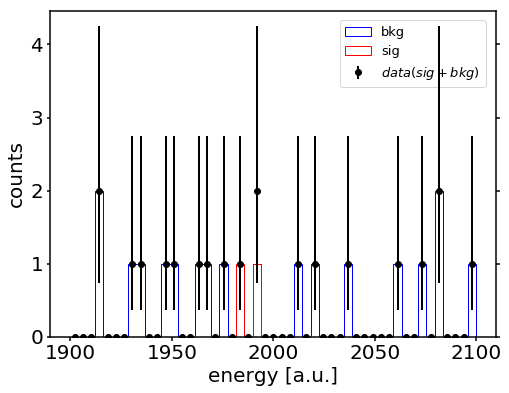

plotting dataset 15


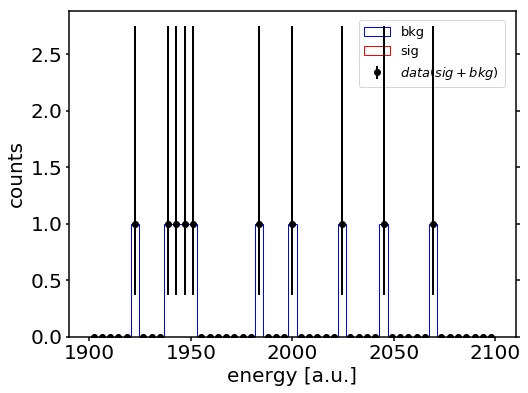

plotting dataset 16


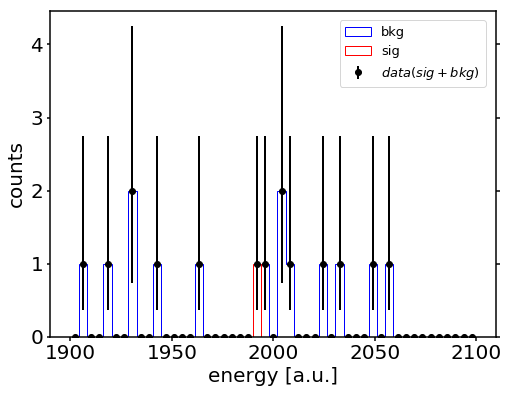

plotting dataset 17


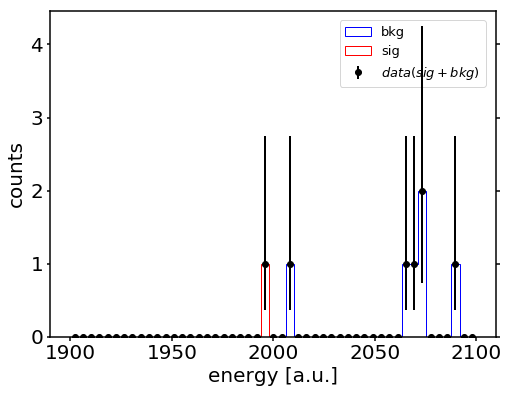

plotting dataset 18


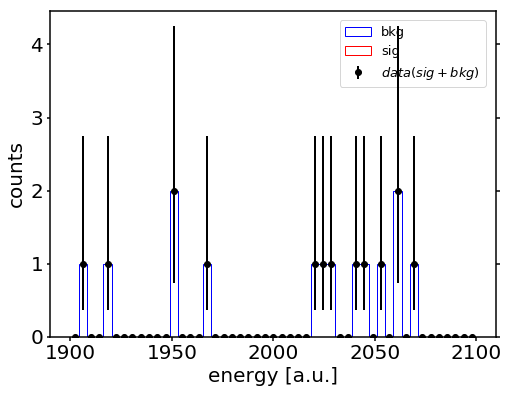

plotting dataset 19


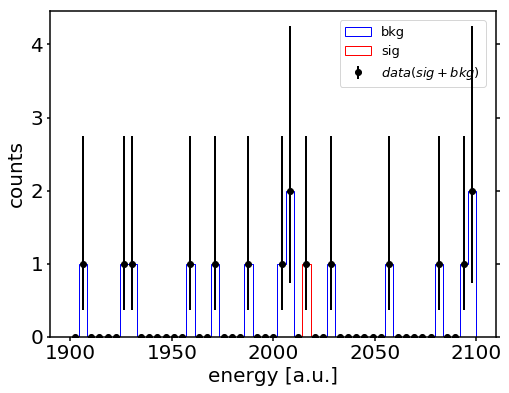

In [2]:
from helpers import get_poisson_confidence_intervals

def plot_datasets(x_b, x_s):
    edges = np.linspace(xmin, xmax, 50)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    
    cb, _, _ = plt.hist(x_b, bins=edges, label='bkg', histtype='step', color='blue')
    cs, _, _ = plt.hist(x_s, bins=edges, label='sig', histtype='step', color='red')
    ctot = cb + cs
    ctot_low, ctot_up = get_poisson_confidence_intervals(ctot)
    
    centers = 0.5*(edges[1:]+edges[:-1])
    ax.errorbar(centers, ctot, yerr=[ctot_low, ctot_up], label='$data (sig+bkg)$', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)

    ax.set_xlabel('energy [a.u.]', fontsize=20)
    ax.set_ylabel('counts', fontsize=20)
    for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(1.5)
              ax.spines[axis].set_color('0.0')
    
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
    ax.yaxis.set_ticks_position('both')
    
    plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

    plt.show()
   

for i in range(len(x_obs_b)):
    print "plotting dataset", i
    plot_datasets(x_obs_b[i], x_obs_s[i])

In [3]:
# concatenate signal and background observations
# and ensure that vectors have same length through padding with arbitrary values
x_obs = copy.copy(x_obs_b)

for i in range(len(x_obs)):
  x_obs[i] = np.concatenate([x_obs_b[i], x_obs_s[i]])
  n_pad = n_obs_max-len(x_obs[i])
  x_obs[i] = np.concatenate([x_obs[i], -1000000*np.ones(n_pad)])
  #print(len(x_obs[i]))
  #print(x_obs[i])

In [4]:
pp_code = """
data {
        int<lower=0> ndatasets;
        int<lower=0> nobs_max;
        int<lower=0> nobs[ndatasets];
        row_vector[nobs_max] xobs[ndatasets];
        real<lower=0> time;
        real<lower=0> gaussian_mean;
        real<lower=0> gaussian_sigma;
        real xmin;
        real xmax;
}

parameters {
        real<lower=0> lambda_s;
        real<lower=0> lambda_b[ndatasets];
        real<lower=0> lambda_b_mean;
        real<lower=0> lambda_b_sigma;
}

transformed parameters {

        // total expectation per dataset
        vector[ndatasets] mu_tot;
         // signal_fraction in mixture for each dataset
        vector[ndatasets] p_s;

        for(i in 1:ndatasets) {
                mu_tot[i] = (lambda_s + lambda_b[i]) * time;
                p_s[i] = lambda_s / (lambda_s + lambda_b[i]);
        }
}

model {
        // priors (arbitrary range for now)
        lambda_s ~ uniform(0, 100);
        lambda_b_mean ~ uniform(0, 100);
        lambda_b_sigma ~ cauchy(0, 25);
        lambda_b ~ normal(lambda_b_mean, lambda_b_sigma);

        // likelihood
        for(i in 1:ndatasets) {
                // poisson term
                nobs[i] ~ poisson(mu_tot[i]);

                // mixture term
                for(j in 1:nobs[i])
                        target+=log_mix(p_s[i], normal_lpdf(xobs[i][j] | gaussian_mean, gaussian_sigma), uniform_lpdf(xobs[i][j] | xmin, xmax));
        }

}
"""

pp_dat = {'ndatasets' : n_datasets,
                    'nobs_max' : n_obs_max,
                    'nobs' : n_obs,
                    'xobs' : x_obs,
                    'time' : time,
                    'gaussian_mean' : gaussian_mean,
                    'gaussian_sigma' : gaussian_sigma,
                    'xmin' : xmin,
                    'xmax' : xmax}

# set environmental variable STAN_NUM_THREADS
# Use 4 cores per chain
os.environ['STAN_NUM_THREADS'] = "4"
extra_compile_args = ['-pthread', '-DSTAN_THREADS']

sm = pystan.StanModel(model_code=pp_code, extra_compile_args=extra_compile_args)
fit = sm.sampling(data=pp_dat, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a45259f1650c2735a9f9295ba75361d NOW.


In [5]:
print(fit)

Inference for Stan model: anon_model_7a45259f1650c2735a9f9295ba75361d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda_s         0.84  7.2e-3   0.39   0.14   0.56   0.81   1.08   1.69 2929.0    1.0
lambda_b[1]     12.68    0.04   2.55   8.27  10.86   12.5  14.25  18.24 4285.0    1.0
lambda_b[2]      9.95    0.03   2.47   5.42   8.27   9.88  11.47  15.29 6083.0    1.0
lambda_b[3]      7.63    0.04   2.42   3.29   5.85   7.54    9.3  12.54 3926.0    1.0
lambda_b[4]      8.74    0.03   2.35   4.34   7.09   8.68  10.34  13.54 4564.0    1.0
lambda_b[5]     11.49    0.03   2.35   7.28   9.87  11.34   13.0  16.52 6655.0    1.0
lambda_b[6]      9.04    0.03   2.41   4.57   7.39   8.98  10.55  13.87 5043.0    1.0
lambda_b[7]     10.44    0.03   2.41   6.16   8.69  10.32  12.04  15.45 6030.0    1.0
lambda_b[8]     12.46    0.04   2.64 

signal rate


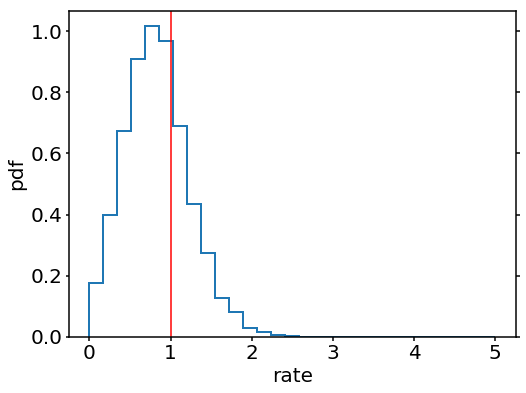

mean background rate


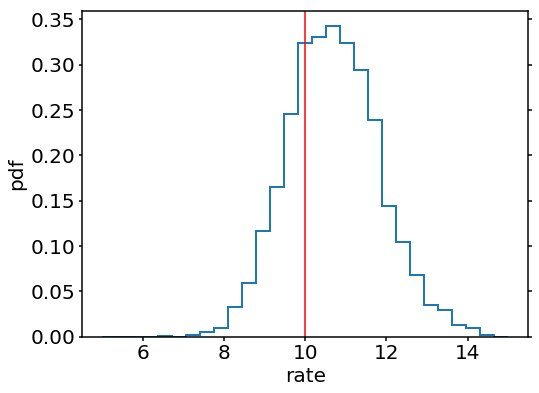

std. deviation of background rate


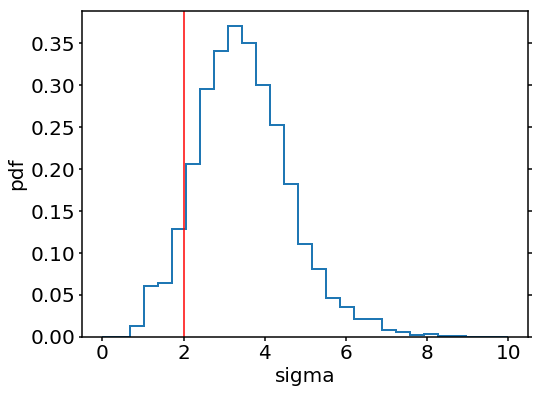

background rate in dataset 0


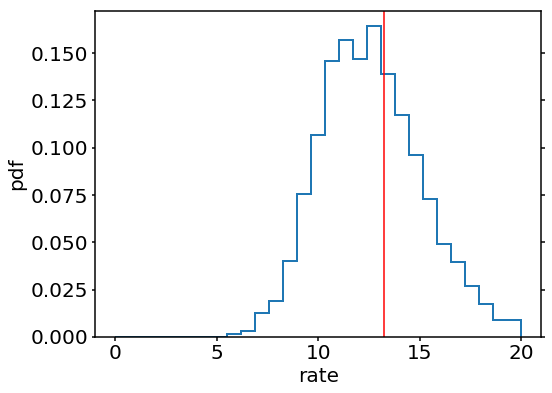

background rate in dataset 1


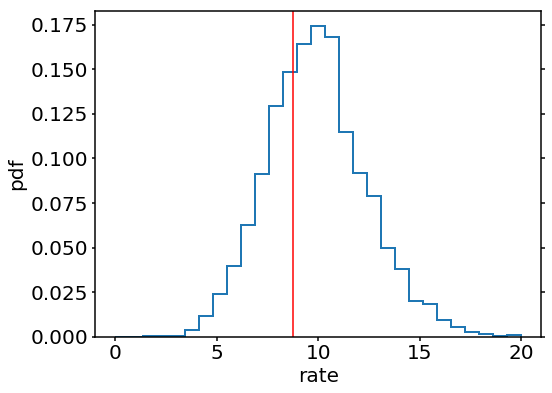

background rate in dataset 2


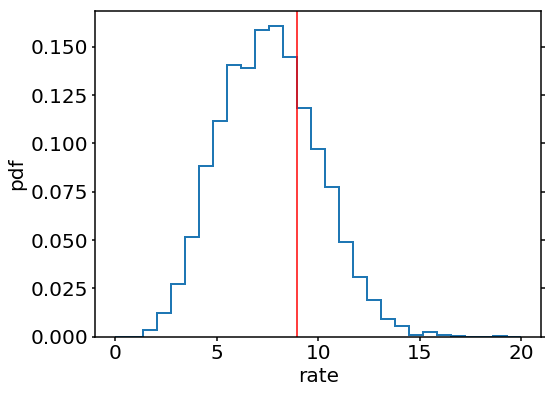

background rate in dataset 3


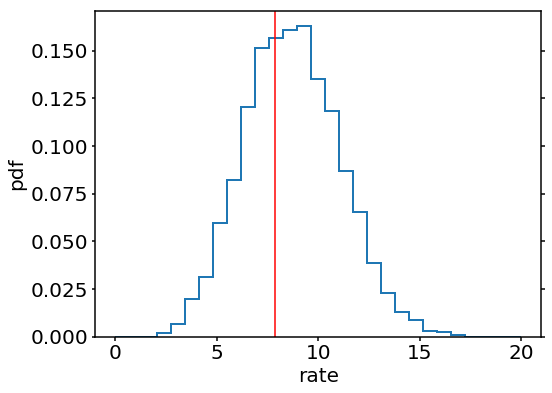

background rate in dataset 4


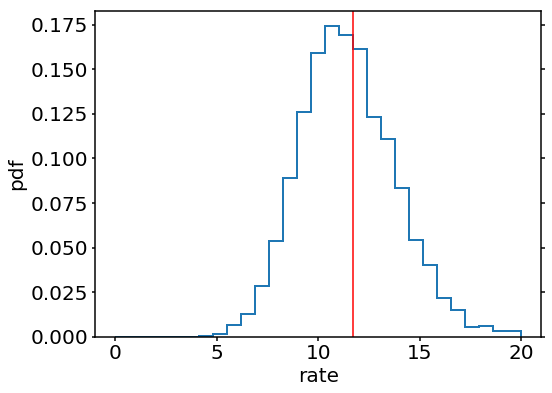

background rate in dataset 5


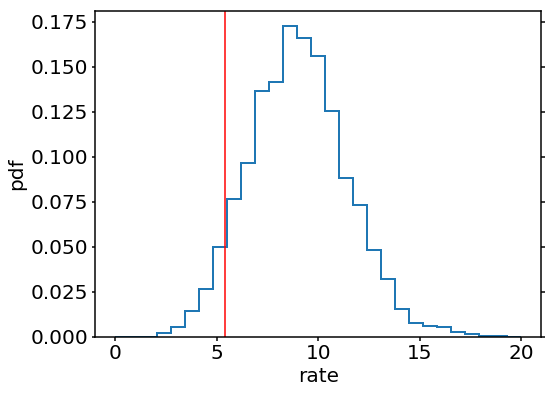

background rate in dataset 6


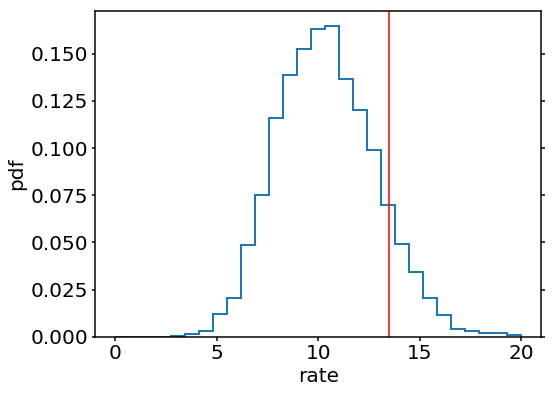

background rate in dataset 7


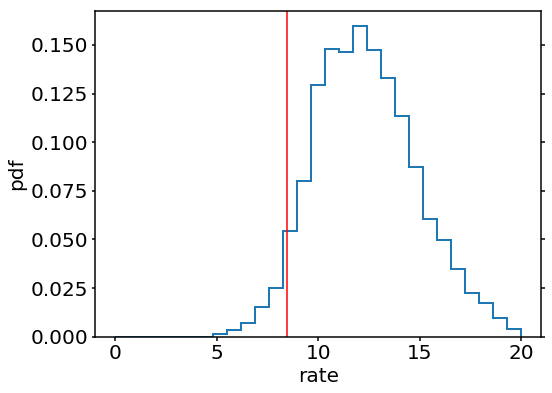

background rate in dataset 8


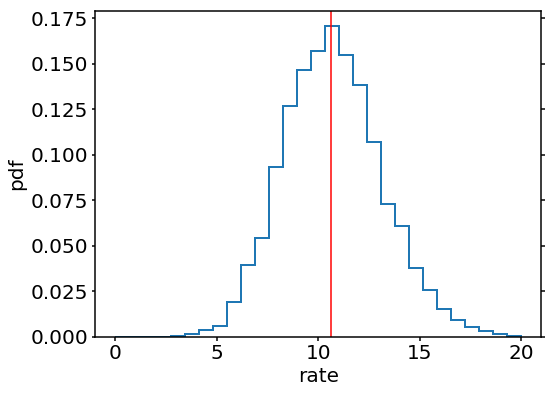

background rate in dataset 9


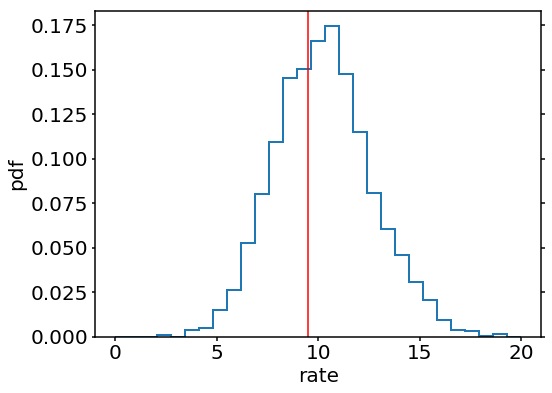

background rate in dataset 10


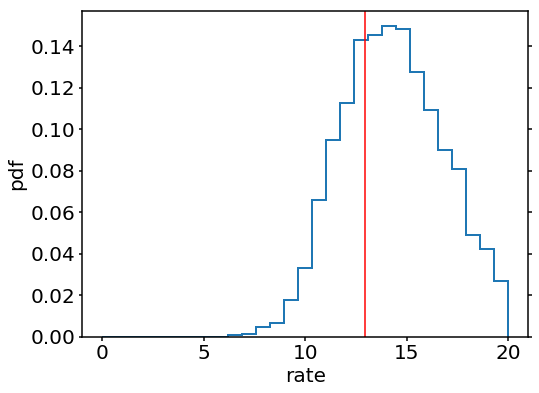

background rate in dataset 11


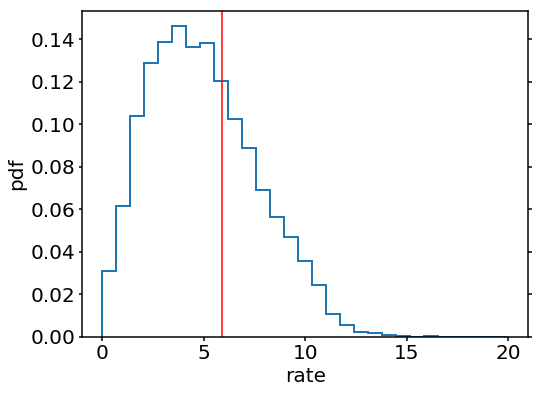

background rate in dataset 12


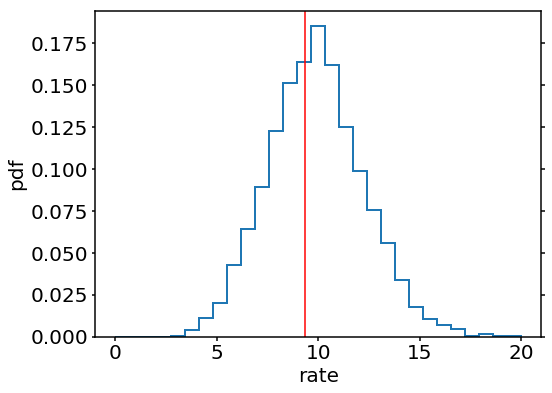

background rate in dataset 13


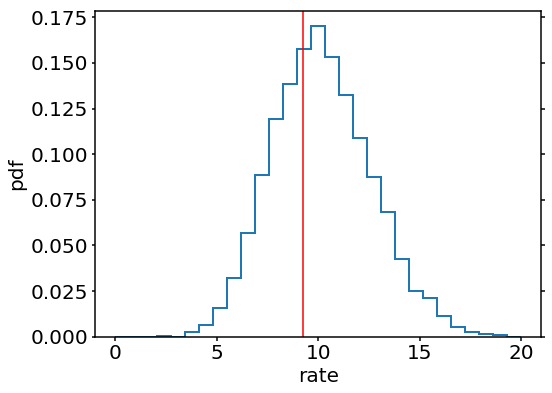

background rate in dataset 14


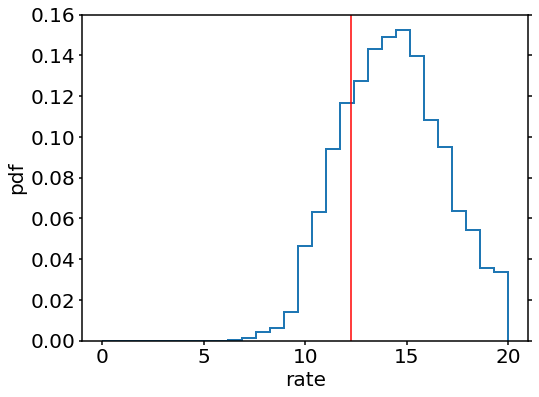

background rate in dataset 15


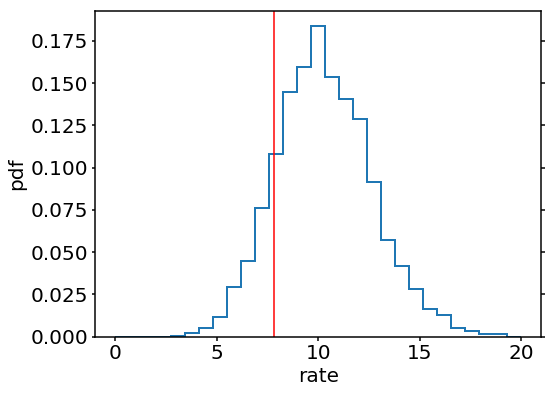

background rate in dataset 16


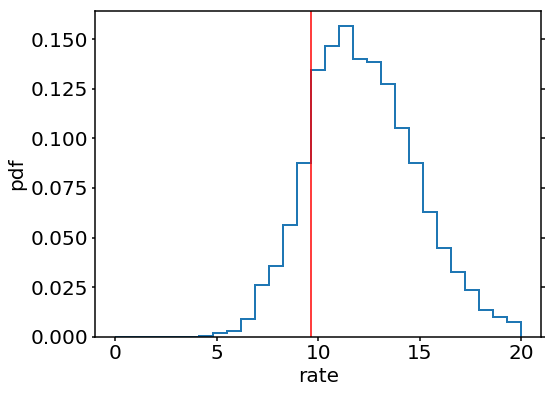

background rate in dataset 17


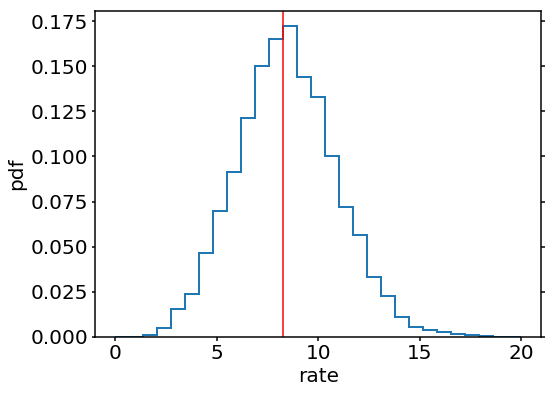

background rate in dataset 18


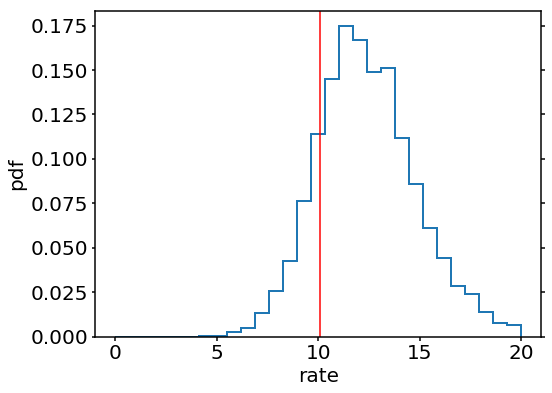

background rate in dataset 19


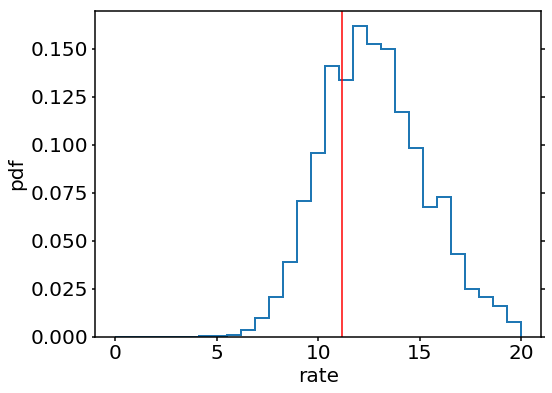

In [6]:
samples = fit.extract()

print "signal rate"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(samples['lambda_s'], bins=np.linspace(0,5,30), histtype='step', density=True, linewidth=2)
ax.set_xlabel('rate', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=lambda_s, color='r')
plt.show()

print "mean background rate"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(samples['lambda_b_mean'], bins=np.linspace(5,15,30), histtype='step', density=True, linewidth=2)
ax.set_xlabel('rate', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=lambda_b_mean, color='r')
plt.show()

print "std. deviation of background rate"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(samples['lambda_b_sigma'], bins=np.linspace(0,10,30), histtype='step', density=True, linewidth=2)
ax.set_xlabel('sigma', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=lambda_b_sigma, color='r')
plt.show()

for i in range(n_datasets):
    print "background rate in dataset", i
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    plt.hist(samples['lambda_b'][:,i], bins=np.linspace(0,20,30), histtype='step', density=True, linewidth=2)
    ax.set_xlabel('rate', fontsize=20)
    ax.set_ylabel('pdf', fontsize=20)
    for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(1.5)
              ax.spines[axis].set_color('0.0')

    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
    ax.yaxis.set_ticks_position('both')
    ax.axvline(x=lambda_b[i], color='r')
    plt.show()